<a href="https://colab.research.google.com/github/sepse/COVAir-Balkans/blob/main/balkan_pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Balkan Air Pollution

We begin this exploratory analysis by loading the common data science libraries to process and visualize the data gathered from air pollution sensors. We will look deeper into the data from 6 Balkan cities.

In [147]:
import numpy as np 
import pandas as pd
from datetime import datetime
import folium

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

#df= pd.read_csv(url, parse_dates=['timestamp'])
pr= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Balkan Air&COVID/air/Prishtina.csv', sep=';')
bl= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Balkan Air&COVID/air/Banjaluka.csv', sep=';')
bg= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Balkan Air&COVID/air/Belgrade.csv', sep=';')
sk= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Balkan Air&COVID/air/Skopje.csv', sep=';')
tr= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Balkan Air&COVID/air/Tirana.csv', sep=';')
zg= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Balkan Air&COVID/air/Zagreb.csv', sep=';')

df = pd.concat([pr, bl, bg, sk, tr, zg], ignore_index=True)

df.sample(5)


,sensor_id,sensor_type,location,lat,lon,timestamp,P1,durP1,ratioP1,P2,durP2,ratioP2
2494840,48623,SDS011,34422,45.80200,16.114000,2021-05-04T04:43:26,23.20,NaN,NaN,17.02,NaN,NaN
1941901,11964,SDS011,6042,41.32600,19.826000,2021-03-03T19:39:45,35.30,NaN,NaN,18.30,NaN,NaN
1854184,11964,SDS011,6042,41.32600,19.826000,2021-12-27T09:52:00,5.27,NaN,NaN,3.93,NaN,NaN
2305896,48623,SDS011,34422,45.80200,16.114000,2021-09-28T23:24:03,23.98,NaN,NaN,16.67,NaN,NaN
1534017,39544,SDS011,25221,41.99597,21.418337,2022-03-24T13:19:38,9.57,NaN,NaN,6.32,NaN,NaN


After getting an intial sample from the dataset, we will select only the variables that are relevant to our study, namely the Location, Coordinates, Date, PM2.5 and PM10; and drop the rest.

In [148]:
df=df.drop(['sensor_type', 'durP1', 'ratioP1', 'durP2', 'ratioP2', 'location'], axis=1)
df.head(5)

,sensor_id,lat,lon,timestamp,P1,P2
0,32198,42.656,21.156,2022-03-15T00:00:21,87.80,46.95
1,32198,42.656,21.156,2022-03-15T00:02:47,82.63,45.70
2,32198,42.656,21.156,2022-03-15T00:05:17,72.38,43.35
3,32198,42.656,21.156,2022-03-15T00:07:43,77.18,42.45
4,32198,42.656,21.156,2022-03-15T00:10:09,77.50,47.35


The dtaset is further refined by replacing 'Sensor ID' with the corresponging city it represents, then we take a look at a sample.

In [149]:
df['sensor_id'] = df['sensor_id'].astype(str) 
df=df.replace(['32198', '11964', '21152', '34876', '39544', '48623'], ['Prishtina', 'Tirana', 'Belgrade', 'Banja Luka', 'Skopje', 'Zagreb'])

df.sample(10)

,sensor_id,lat,lon,timestamp,P1,P2
2153310,Tirana,41.32600,19.826000,2022-01-14T02:06:44,6.83,4.90
1193382,Belgrade,44.79200,20.482000,2020-10-11T05:17:12,17.83,15.63
1587181,Skopje,41.99597,21.418337,2022-04-27T16:06:58,9.20,2.40
517105,Banja Luka,44.78000,17.194000,2020-09-22T01:34:30,14.75,10.90
2136819,Tirana,41.32600,19.826000,2022-03-12T08:38:36,5.80,4.00
1903000,Tirana,41.32600,19.826000,2021-06-03T04:54:14,23.80,4.93
2000644,Tirana,41.32600,19.826000,2021-02-27T18:49:20,90.40,46.37
98802,Prishtina,42.65600,21.156000,2019-11-29T12:52:27,12.77,3.60
1980902,Tirana,41.32600,19.826000,2021-11-07T08:39:57,10.10,5.30
71281,Prishtina,42.65600,21.156000,2019-11-03T04:20:26,9.23,7.43


In order to perform numerical processing with the python libraries it is essential to first look at the dtatypes the variables are stored in, and if they need adjusting. 

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602069 entries, 0 to 2602068
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   sensor_id  object 
 1   lat        float64
 2   lon        float64
 3   timestamp  object 
 4   P1         float64
 5   P2         float64
dtypes: float64(4), object(2)
memory usage: 119.1+ MB


'Timestamp' feature needs to be formatted as a proper date so we can perform time-series analysis.

In [151]:
# Convert string to datetime64
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602069 entries, 0 to 2602068
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sensor_id  object        
 1   lat        float64       
 2   lon        float64       
 3   timestamp  datetime64[ns]
 4   P1         float64       
 5   P2         float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 119.1+ MB


In the cell below we visualize our sensor coordinates data in the map, and see where are the sensors located.

In [152]:
map = folium.Map(location=[44.137, 19.142577], width='40%', height='40%', tiles="CartoDB Positron", zoom_start=6)


folium.Marker(location=[42.646, 21.1485], popup="Prishtine", icon=folium.Icon(icon="cloud"),).add_to(map)
folium.Marker(location=[44.78,	17.194], popup="Banja Luka", icon=folium.Icon(icon="cloud"),).add_to(map)
folium.Marker(location=[44.792,	20.482], popup="Belgrade", icon=folium.Icon(icon="cloud"),).add_to(map)
folium.Marker(location=[41.99597,	21.418337], popup="Skopje", icon=folium.Icon(icon="cloud"),).add_to(map)
folium.Marker(location=[41.326,	19.826], popup="Tirana", icon=folium.Icon(icon="cloud"),).add_to(map)
folium.Marker(location=[45.802, 16.114], popup="Zagreb", icon=folium.Icon(icon="cloud"),).add_to(map)

map

In [153]:
print(f"The available data is between {df['timestamp'].min()} and {df['timestamp'].max()}")

The available data is between 2019-10-15 00:00:00 and 2022-05-04 23:59:02


In [154]:
type(df.index)

pandas.core.indexes.range.RangeIndex

Before we delve deeper into the individual countries, we plot all our data so we can get an initial snapshot at the big picture.

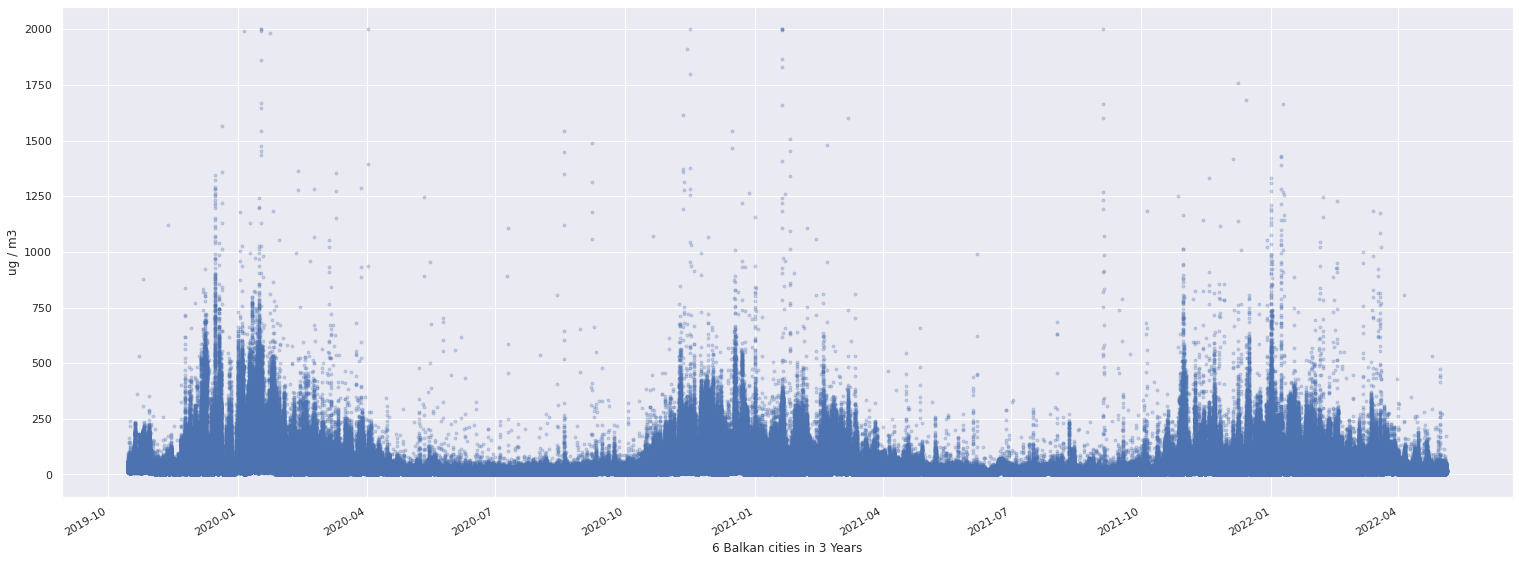

In [155]:
df.set_index('timestamp',inplace=True)
axes = df['P1'].plot(marker='.', alpha=0.25, linestyle='None', figsize=(26, 10), subplots=True)
for ax in axes:
    
    ax.set_xlabel('6 Balkan cities in 3 Years')
    ax.set_ylabel('ug / m3')

We can clearly see a trend emerging, which give us a hint into further understanding the phenomenon. It seems interesting to break down the trends into yearly and monthly plots with respective distibutions, which will give us a perspective on how trends emerge on lower timescales.

In [156]:
def trend_plot(dataframe,value):
    
    # Prepare data
    df['year'] = [d.year for d in df.timestamp]
    df['month'] = [d.month for d in df.timestamp]
    years = df['year'].unique()

    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(26,6), dpi= 80)
    boxplot = sns.boxplot(x='year', y=value, data=df, ax=axes[0])
    boxplot.set(yscale="log") #yscale=log sets the boxplot to logarithmic to zoom into data
    sns.pointplot(x='month', y=value, data=df.loc[~df.year.isin([2019, 2022]), :])

    # Set Title
    axes[0].set_title('Year-wise Box Plot \n(The Trend)', fontsize=18); 
    axes[1].set_title('Month-wise Plot \n(The Seasonality)', fontsize=18)
    
    plt.show()

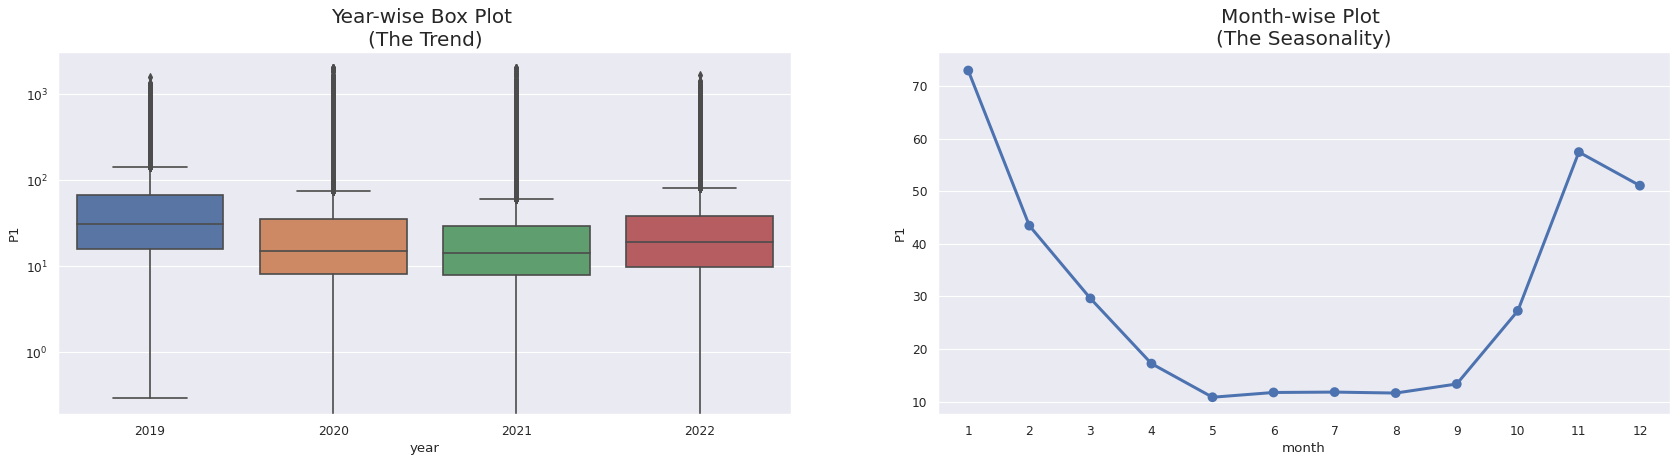

In [157]:
df.reset_index(inplace=True)
df = df.copy()
value='P1'
trend_plot(df,value)

Not surprisingly, we can see that most polluted months are during Fall and Winter, as it coincided with burning of fuels for heating. In the following cells, we begin to break down the data into city-levels, and get an understanding about individual city pollution levels.

In [158]:
pollutants = ['P1','P2']

In [159]:
def max_polluted_city(pollutant):
    x1 = df[[pollutant,'sensor_id']].groupby(["sensor_id"]).mean().sort_values(by=pollutant,ascending=False).reset_index()
    x1[pollutant] = round(x1[pollutant],2)
    return x1[:10].style.background_gradient(cmap='OrRd')

In [160]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.render()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [161]:
pm2_5 = max_polluted_city('P1')
pm10 = max_polluted_city('P2')

display_side_by_side(pm2_5,pm10)


,sensor_id,P1
0,Belgrade,40.440000
1,Prishtina,40.240000
2,Banja Luka,35.440000
3,Zagreb,31.570000
4,Skopje,27.130000
5,Tirana,15.540000
,sensor_id,P2
0,Belgrade,22.340000
1,Prishtina,20.770000
2,Banja Luka,18.200000


In the previous cell we get an idea about the **Mean Average** pollution levels, for the period we have data. Whereas below we will compute the **Median Average** pollution levels.

In [162]:
x2 = df[['P1','sensor_id']].groupby(["sensor_id"]).median().sort_values(by='P1',ascending=False).reset_index()
x3 = df[['P2','sensor_id']].groupby(["sensor_id"]).median().sort_values(by='P2',ascending=False).reset_index()

from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2, subplot_titles=("PM2.5","PM10"))


fig.add_trace(go.Bar( y=x2['P1'], x=x2["sensor_id"],  
                     marker=dict(color=x2['P1'], coloraxis="coloraxis")), 1, 1)


fig.add_trace(go.Bar( y=x3['P2'], x=x2["sensor_id"],  
                     marker=dict(color=x3['P2'], coloraxis="coloraxis")), 1, 2)

fig.update_layout(coloraxis=dict(colorscale='reds'), showlegend=False,plot_bgcolor='white')
fig.update_xaxes(ticks="outside", tickwidth=2,tickangle=45, tickcolor='crimson', ticklen=10,title_text="6 Cities Median")
fig.update_yaxes(title_text="ug / m3", row=1, col=1)
fig.update_yaxes(title_text="ug / m3", row=1, col=2)

fig.show()



We see different rankings based on how we compute the averages, and they communicate different characteristics of the cities in the sample. In that case we should look further into individual city analysis and see if we find patterns that give us better insights.

In [163]:
cities = ['Prishtina','Belgrade','Banja Luka','Zagreb','Tirana','Skopje']

filtered_city_day = df[df['timestamp'] >= '2019-01-01']
AQI = filtered_city_day[filtered_city_day.sensor_id.isin(cities)][['timestamp','sensor_id','P1','P2']]
AQI.head()





,timestamp,sensor_id,P1,P2
0,2022-03-15 00:00:21,Prishtina,87.80,46.95
1,2022-03-15 00:02:47,Prishtina,82.63,45.70
2,2022-03-15 00:05:17,Prishtina,72.38,43.35
3,2022-03-15 00:07:43,Prishtina,77.18,42.45
4,2022-03-15 00:10:09,Prishtina,77.50,47.35


By plotting individual city pollution graphs, we can clearly see different pollution profiles. Some have more pronounced intensity, while others have pronounced consistency; explaining the difference between the mean/median average values.

Text(0.5, 1.0, 'Zagreb')

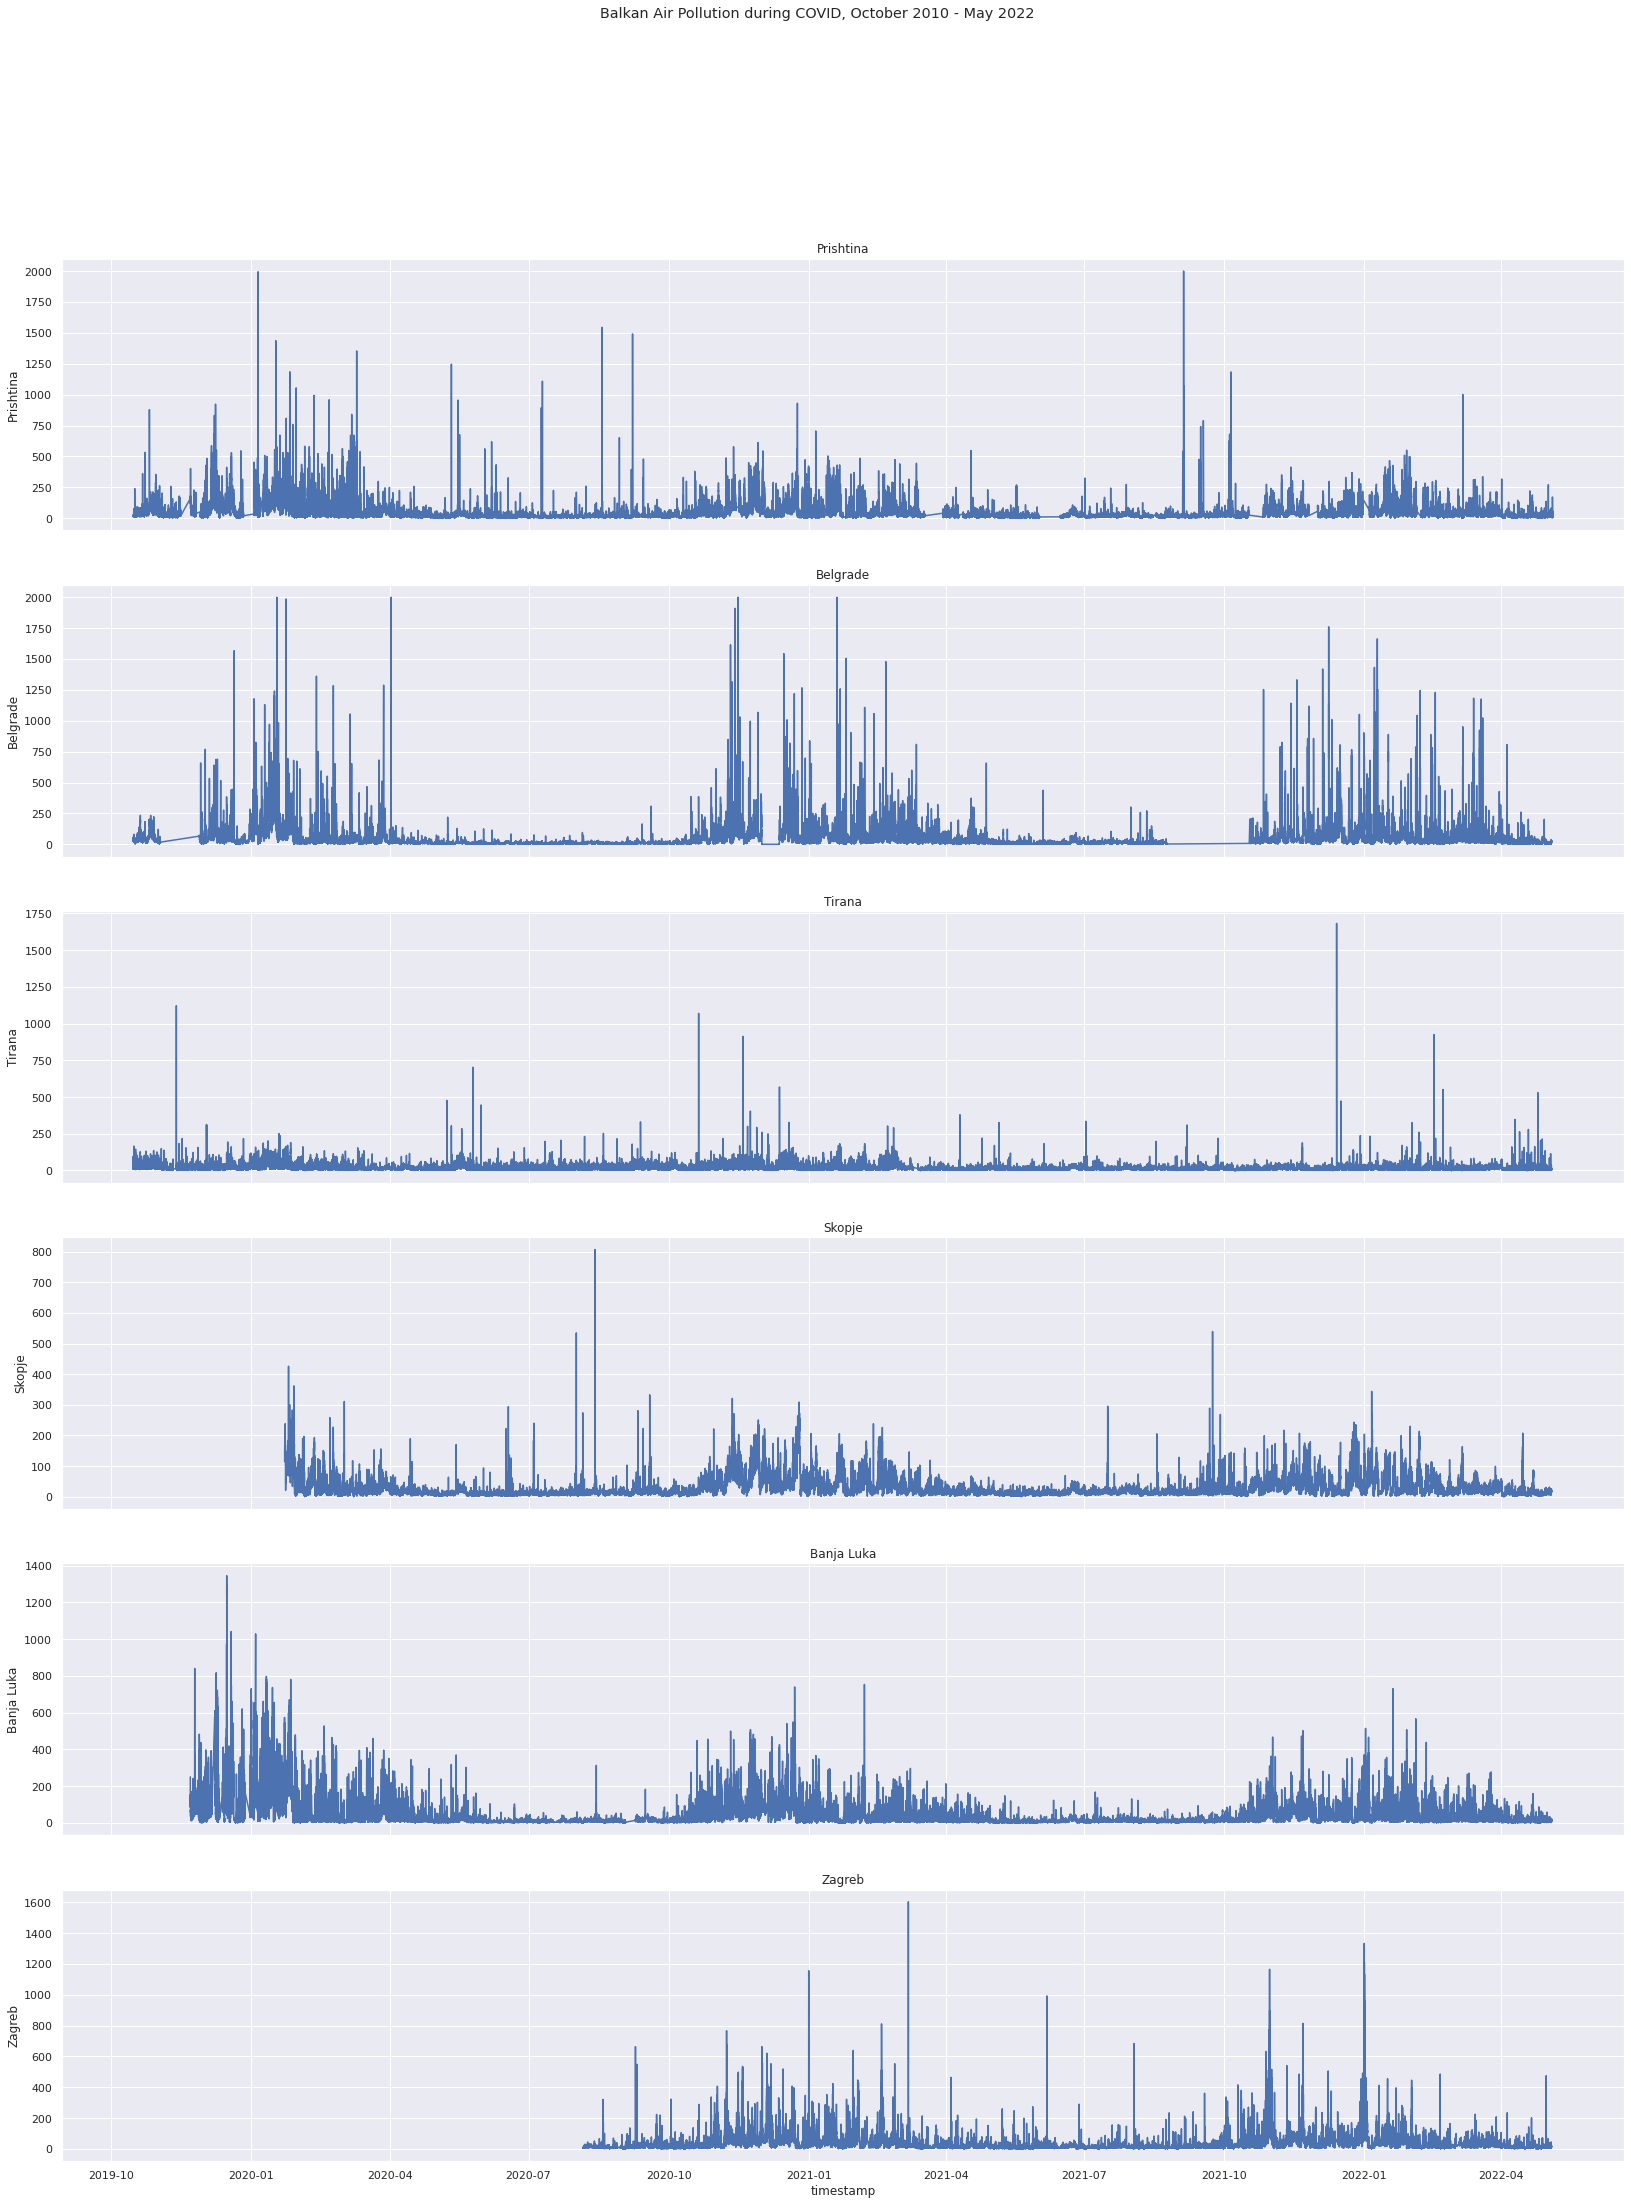

In [164]:
AQI_pivot = AQI.pivot(index='timestamp', columns='sensor_id', values='P1')

fig, axes = plt.subplots(6, 1, figsize=(28, 35), sharex=True)
fig.suptitle('Balkan Air Pollution during COVID, October 2010 - May 2022')

# Prishtina
sns.lineplot(ax=axes[0], x=AQI_pivot.index, y=AQI_pivot['Prishtina'], data=AQI_pivot).set_title("Prishtina")

# Belgrade
sns.lineplot(ax=axes[1], x=AQI_pivot.index, y=AQI_pivot['Belgrade'], data=AQI_pivot).set_title("Belgrade")

# Tirana
sns.lineplot(ax=axes[2], x=AQI_pivot.index, y=AQI_pivot['Tirana'], data=AQI_pivot).set_title("Tirana")

# Skopje
sns.lineplot(ax=axes[3], x=AQI_pivot.index, y=AQI_pivot['Skopje'], data=AQI_pivot).set_title("Skopje")

# Banja Luka
sns.lineplot(ax=axes[4], x=AQI_pivot.index, y=AQI_pivot['Banja Luka'], data=AQI_pivot).set_title("Banja Luka")

# Zagreb
sns.lineplot(ax=axes[5], x=AQI_pivot.index, y=AQI_pivot['Zagreb'], data=AQI_pivot).set_title("Zagreb")

It is clear that every city has a different pollution profile, some chronic and some acute, which merits further investigation as to what the real culprit is (Power plant, Household heating, Industrial activities, Vehicle traffic). One key takeaway from this study is the effect that COVID pandemic has had on the air pollution, namely pollution levels dropping after the introduction of lockdowns in the cities. Graphs suggest that vehicle traffic could be one of the key pollutants in the city. Regardless, this exploratory study serves as a insightful exercise to further understand our surroundings using data science tools. 